# Data analysis
In this iPython notebook, we analyse the data produced by the basic stock market model

* Price versus time (check)
* volatility of price  / std versus time (check)
* 4 color codes: chartist fundamentalist transactions 
* plot fundamental values 

In [1]:
%matplotlib inline
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
import ast
import json
import re
style.use('seaborn-darkgrid')

In [2]:
function_string = '<function predict_by_moving_avg_growth at 0x000002B96999C840>'

In [3]:
function_string.find(' at')

38

In [4]:
function_string[function_string.find(' ')+1:function_string.find(' at')]

'predict_by_moving_avg_growth'

First, I open a connection to the database

In [5]:
#%cd C:/Users/joerischasfoort/Documents/GitHub/abm/

In [6]:
conn = sqlite3.connect('dataBaseOffline.sqlite')
cur = conn.cursor()

In [7]:
NRUNS = 1

## 1 State variables 
Using the Statevariables, Variabletypes and Objects tables, I then analyse the state variables of the simulated objects: stocks, firms, and traders. 
### 1.1 Stocks 
The state variables of stocks are: 
* the firm the stock links to,
* the face value,
* the amount of stocks outstanding. 

In this version of the model these variables are static. 

In [8]:
stockVariables = []
for seed in range(NRUNS):
    stockVariables.append(pd.read_sql_query(
    """
    SELECT Statevariables{0}.seed ,Statevariables{0}.period, Variabletypes{0}.variable_type, Objects{0}.object_name, Objects{0}.object_type ,Statevariables{0}.value 
    FROM Statevariables{0} JOIN Variabletypes{0} JOIN Objects{0} ON Statevariables{0}.variable_id = Variabletypes{0}.id and Statevariables{0}.owner_id = Objects{0}.id 
    WHERE Objects{0}.object_type = 'stock'
    """.format(seed), conn))

In [9]:
stockVariables = pd.concat(stockVariables)

In [10]:
stocks = {}
for seed in range(NRUNS):
    allStocks = []
    for stock in set(stockVariables['object_name']):
        allStocks.append(stockVariables.query('variable_type == "amount" and object_name == "{}" and seed == {}'.format(stock, seed))['value'])
    stocks['run_' + str(seed)] = allStocks

In [11]:
facevalues = {}
for seed in range(NRUNS):
    allStocks = []
    for stock in set(stockVariables['object_name']):
        allStocks.append(stockVariables.query('variable_type == "face_value" and object_name == "{}" and seed == {}'.format(stock, seed))['value'])
    facevalues['run_' + str(seed)] = allStocks

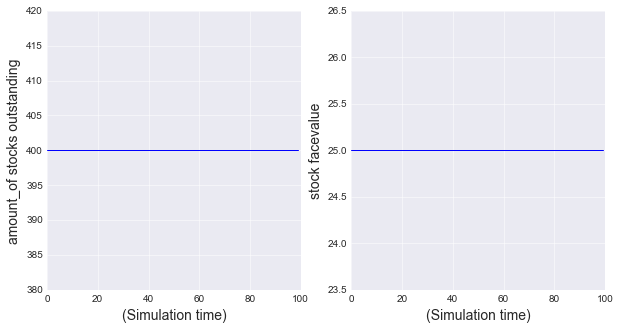

In [12]:
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

for stock in stocks['run_0']:
    ax1.plot(range(len(stock)), stock.apply(int))

for faceVal in facevalues['run_0']:
    ax2.plot(range(len(faceVal)), faceVal.apply(float))

ax1.set_xlabel('(Simulation time)', fontsize='14')
ax2.set_xlabel('(Simulation time)', fontsize='14')
ax1.set_ylabel('amount_of stocks outstanding', fontsize='14')
ax2.set_ylabel('stock facevalue', fontsize='14')

#ax1.legend(loc=2, fontsize='14')

### 1.2 Firms 
The state variables of firms are: 
* profit
* bookvalue (*fixed*), 
* dividend rate (*fixed*).

In [13]:
firmVariables = []
for seed in range(NRUNS):
    firmVariables.append(pd.read_sql_query(
    """
    SELECT Statevariables{0}.seed ,Statevariables{0}.period, Variabletypes{0}.variable_type, Objects{0}.object_name, Objects{0}.object_type, Statevariables{0}.value 
    FROM Statevariables{0} JOIN Variabletypes{0} JOIN Objects{0} 
    ON Statevariables{0}.variable_id = Variabletypes{0}.id and Statevariables{0}.owner_id = Objects{0}.id 
    WHERE Objects{0}.object_type = 'firm'
    """.format(seed), conn))

In [14]:
firmVariables = pd.concat(firmVariables)

In [15]:
firmVariables.head()

,seed,period,variable_type,object_name,object_type,value
0,0,0,book_value,firm_0,firm,10000
1,0,0,dividend_rate,firm_0,firm,1
2,0,0,profit,firm_0,firm,192
3,0,0,profit_history,firm_0,firm,"[200, 204, 206, 203, 198, 207, 196, 192]"
4,0,0,name,firm_0,firm,0


In [16]:
firms = {}
for seed in range(NRUNS):
    allFirms = []
    for firm in set(firmVariables['object_name']):
        allFirms.append(firmVariables.query('variable_type == "profit" and object_name == "{}" and seed == {}'.format(firm, seed))['value'])
    firms['run_' + str(seed)] = allFirms

#### 1.2.1 Firm profits

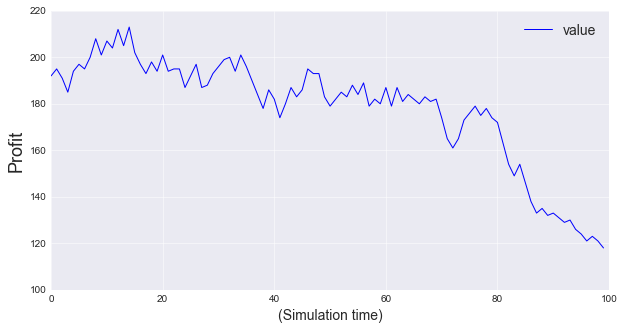

In [17]:
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(111)

for firm in firms['run_0']:
    ax1.plot(range(len(firm)), firm.apply(int))

ax1.set_xlabel('(Simulation time)', fontsize='14')
ax1.set_ylabel('Profit', fontsize='18')

plt.legend(loc='best', fontsize='14')

### 1.3 Traders

In this section, we examine the state variables of traders. These are: 
* Money
* Portfolio of stocks: *The type and amount of that stock agent holds*
* Bid-ask spread (**fixed**): *the percentage difference between the amount at which an agent is willing to buy and sell a stock.*
* Memory size (**fixed**): *the amount of periods an agent remembers stock prices*

In [18]:
traderVariables = []
for seed in range(NRUNS):
    traderVariables.append(pd.read_sql_query(
    """
    SELECT Statevariables{0}.seed ,Statevariables{0}.period, Variabletypes{0}.variable_type, Objects{0}.object_name, Objects{0}.object_type, Statevariables{0}.value 
    FROM Statevariables{0} JOIN Variabletypes{0} JOIN Objects{0} 
    ON Statevariables{0}.variable_id = Variabletypes{0}.id and Statevariables{0}.owner_id = Objects{0}.id 
    WHERE Objects{0}.object_type = 'trader'
    """.format(seed), conn))

In [19]:
traderVariables = pd.concat(traderVariables)

In [20]:
traderVariables.head()

,seed,period,variable_type,object_name,object_type,value
0,0,0,name,trader_29,trader,29
1,0,0,function,trader_29,trader,<function extrapolate_average_profit at 0x0000...
2,0,0,money,trader_29,trader,211.25
3,0,0,bid_ask_spread,trader_29,trader,0
4,0,0,memory_size,trader_29,trader,3


In [21]:
t_time = list(set(traderVariables['period'].apply(int)))

#### 1.3.1 Money:
Over time some traders trade more than other and thus their **money** either increases or decreases. All traders start out with money between 200 and 250 and over time this branches out to a distribution between 0 and 280. 

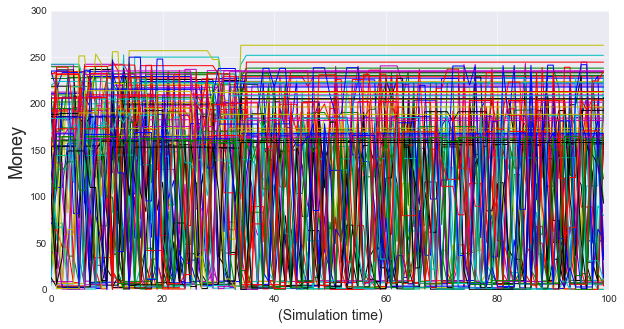

In [22]:
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(111)

for trader in traderVariables['object_name'].unique():
    ax1.plot(t_time, 
            traderVariables.query('variable_type == "money" and object_name == "{}" and seed == 0.0'.format(trader))['value'].apply(float),
            label=trader)

ax1.set_xlabel('(Simulation time)', fontsize='14')
ax1.set_ylabel('Money', fontsize='18')

#plt.legend(loc=2, fontsize='14')

#### 1.3.2 Stock portfolio:
Likewise the distribution of stocks changes as traders trade with each other. 

In [23]:
def transformStringToDict(stringDict):
    """This function inserts double quotation marks into the current dictionary string"""
    original = stringDict
    indis = [m.start() for m in re.finditer('stock_', original)]
    s = original
    counter = 0
    for ix in indis:
        ix = ix + counter
        s = s[:ix] + '"' + s[ix:]
        counter += 1
    dubbelPunten = [m.start() for m in re.finditer(':', original)]
    counter2 = 0
    for ix2 in dubbelPunten:
        ix2 = ix2 + counter2
        s = s[:(ix2+1)] + '"' + s[(ix2+1):]
        counter2 += 2
    d = json.loads(s)
    return d

In [24]:
traderPortfolios = traderVariables.query('variable_type == "stocks"')
traderPortfolios['value'] = traderPortfolios['value'].apply(transformStringToDict)

C:\Users\p267237\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


From the value column we create seperate columns for each stock in the trader portfolio.

In [25]:
stocks = {}
for stock in stockVariables['object_name'].unique():
    stocks[stock] = []
    for i in range(len(traderPortfolios)):
        stocks[stock].append(traderPortfolios['value'].iloc[i][stock])
    traderPortfolios[stock] = stocks[stock]
#traderPortfolios.head()

C:\Users\p267237\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [26]:
traderPortfolios.head()

,seed,period,variable_type,object_name,object_type,value,stock_0
7,0,0,stocks,trader_29,trader,{'stock_0': 0},0
15,0,1,stocks,trader_29,trader,{'stock_0': 0},0
23,0,2,stocks,trader_29,trader,{'stock_0': 0},0
31,0,3,stocks,trader_29,trader,{'stock_0': 0},0
39,0,4,stocks,trader_29,trader,{'stock_0': 0},0


KeyError: 'stock_1'

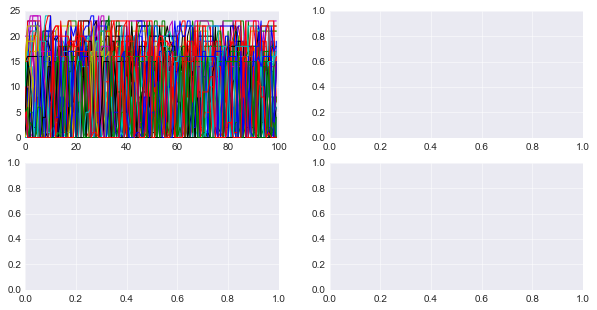

In [27]:
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)

seed = 0

for trader in traderPortfolios['object_name'].unique():
    ax1.plot(t_time, 
            traderPortfolios.query('object_name == "{}" and seed == {}'.format(trader, seed))['stock_0'],
            label=trader)
    
for trader in traderPortfolios['object_name'].unique():
    ax2.plot(t_time, 
            traderPortfolios.query('object_name == "{}" and seed == {}'.format(trader, seed))['stock_1'],
            label=trader)
    
for trader in traderPortfolios['object_name'].unique():
    ax3.plot(t_time, 
            traderPortfolios.query('object_name == "{}" and seed == {}'.format(trader, seed))['stock_2'],
            label=trader)
    
for trader in traderPortfolios['object_name'].unique():
    ax4.plot(t_time, 
            traderPortfolios.query('object_name == "{}" and seed == {}'.format(trader, seed))['stock_3'],
            label=trader)

ax1.set_ylabel('Stock_0', fontsize='18')
ax2.set_ylabel('Stock_1', fontsize='18')
ax3.set_xlabel('(Simulation time)', fontsize='14')
ax3.set_ylabel('Stock_2', fontsize='18')

ax3.set_xlabel('(Simulation time)', fontsize='14')
ax4.set_ylabel('Stock_3', fontsize='18')

#plt.legend(loc=2, fontsize='14')

## 2 Transactions
Using the Transactions and Objects tables, I then analyse the transactions made by traders. 

In [28]:
transactions = []
for seed in range(NRUNS):
    transactions.append(pd.read_sql_query(
    """
    SELECT Transactions{0}.id, Transactions{0}.seed, Transactions{0}.period, Transactors{0}.role, Objects{0}.object_name, Objects{0}.object_type, Transactions{0}.amount_of_product, Transactions{0}.amount_of_money 
    FROM Transactors{0} JOIN Transactions{0} JOIN Objects{0} 
    ON Transactors{0}.transaction_id = Transactions{0}.id and Transactors{0}.transactor_id = Objects{0}.id
    """.format(seed), conn))

In [29]:
transactions = pd.concat(transactions)

The price of transactions is not recorded in the simulation. Therefore, I derive it by dividing the amount of money payed for a single transactions by the amount of stocks traded. 

In [30]:
transactions['price'] = transactions['amount_of_money'] / transactions['amount_of_product']

In [31]:
transactions.tail()

,id,seed,period,role,object_name,object_type,amount_of_product,amount_of_money,price
5128,1709,0,99,seller,trader_64,trader,8,83.384323,10.42304
5129,1709,0,99,stock,stock_0,stock,8,83.384323,10.42304
5130,1710,0,99,buyer,trader_70,trader,15,156.345606,10.42304
5131,1710,0,99,seller,trader_79,trader,15,156.345606,10.42304
5132,1710,0,99,stock,stock_0,stock,15,156.345606,10.42304


### 2.1 Prices 
A stock can be traded at different prices at the same time by different traders. I therefore construct a seperate table which summarizes stocks prices over time. 

In [32]:
transactionTime = [n for n in range(len(t_time))]

In [33]:
seed = 0

stockPrices = {'period': transactionTime}
for stock in transactions.query('object_type == "stock"')['object_name'].unique():
    allPrices = []
    for period in transactionTime:
        pricesAtPeriod = []
        for price in transactions.query('object_name == "{}" and period == {} and seed == {}'.format(stock,period, seed))['price']:
            pricesAtPeriod.append(price)
        if (not not pricesAtPeriod):
            allPrices.append(pricesAtPeriod)
        else:
            allPrices.append(np.nan)
    stockPrices[stock] = allPrices

In [34]:
pricesOvertime = pd.DataFrame(stockPrices)
pricesOvertime.head()

,period,stock_0
0,0,"[9.78333333333, 9.78333333333, 9.78333333333, ..."
1,1,"[9.33624494609, 9.33624494609, 9.875, 9.336244..."
2,2,"[9.20506577131, 9.51124854387, 9.20506577131, ..."
3,3,"[9.5375, 9.59, 9.5375, 9.5375, 9.51666666667, ..."
4,4,"[9.57, 9.5625, 9.60833333333, 9.57, 9.45964448..."


### 2.1.1 Average prices

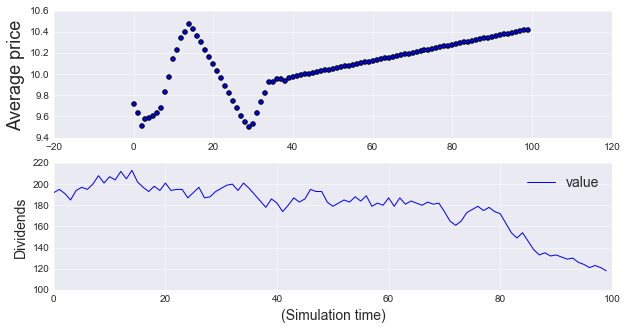

In [35]:
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

ax1.scatter(pricesOvertime.index, pricesOvertime['stock_0'].apply(np.mean), c='b')
# ax1.scatter(pricesOvertime.index, pricesOvertime['stock_1'].apply(np.mean), c='g')
# ax1.scatter(pricesOvertime.index, pricesOvertime['stock_2'].apply(np.mean), c='r')
# ax1.scatter(pricesOvertime.index, pricesOvertime['stock_3'].apply(np.mean), c='y')

for firm in firms['run_0']:
    ax2.plot(range(len(firm)), firm.apply(int))

ax2.set_ylabel('Dividends', fontsize='14')
ax2.set_xlabel('(Simulation time)', fontsize='14')
ax1.set_ylabel('Average price', fontsize='18')

plt.legend(loc='best', fontsize='14')
fig.savefig('pricesAndDividends.png')

### 2.2 Volume

In [36]:
transactions.head()

,id,seed,period,role,object_name,object_type,amount_of_product,amount_of_money,price
0,0,0,0,buyer,trader_29,trader,5,48.916667,9.783333
1,0,0,0,seller,trader_43,trader,5,48.916667,9.783333
2,0,0,0,stock,stock_0,stock,5,48.916667,9.783333
3,1,0,0,buyer,trader_22,trader,5,48.916667,9.783333
4,1,0,0,seller,trader_64,trader,5,48.916667,9.783333


In [37]:
def dfOfVolumesPerStock(transactionsDataFrame, listOfStocks, SIMULATIONTIME):
    groupedTransactions = transactionsDataFrame.groupby(['period', 'object_name'])
    tradeVolumePerStock = {}
    for stock in listOfStocks:
        tradeVolume = []
        for time in [n for n in range(SIMULATIONTIME)]:
            try:
                volume = groupedTransactions.get_group((time, stock))['amount_of_product'].sum()
            except:
                volume = 0
            tradeVolume.append(volume)
        tradeVolumePerStock[stock] = tradeVolume
    return pd.DataFrame(tradeVolumePerStock)

In [38]:
STOCKS = list(set(stockVariables['object_name']))
volumesPerStock = dfOfVolumesPerStock(transactions.query('seed == 0'), STOCKS, 100)

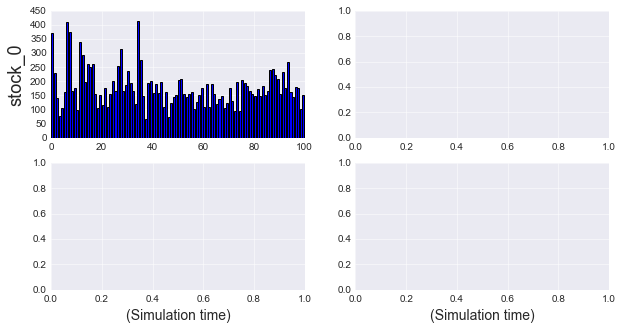

In [39]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10,5))

for stock, ax in list(zip(STOCKS, [ax1,ax2,ax3,ax4])):
    ax.bar(volumesPerStock.index, volumesPerStock[stock])
    ax.set_ylabel(stock, fontsize='18')

ax3.set_xlabel('(Simulation time)', fontsize='14')
ax4.set_xlabel('(Simulation time)', fontsize='14')

fig.savefig('tradeVolumes.png')

## Volumes and prices 

C:\Users\p267237\AppData\Local\Continuum\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


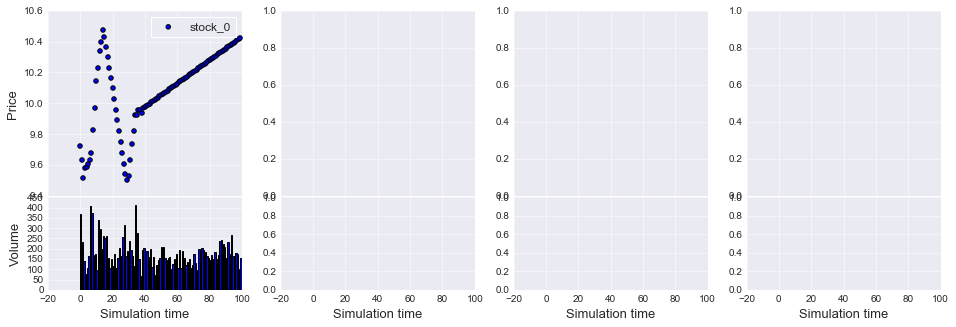

In [40]:
# Three subplots sharing both x/y axes
#fig, ((ax1, ax2)) = plt.subplots(2, figsize=(6, 6), sharex=True,gridspec_kw={'height_ratios':[2,1]})
fig, ((ax1, ax2, ax3, ax4), (ax5, ax6, ax7, ax8)) = plt.subplots(2, 4, figsize=(16,5), sharex=True, gridspec_kw={'height_ratios':[2,1]})
priceAxes = (ax1, ax2, ax3, ax4) 
volumeAxes = (ax5, ax6, ax7, ax8)

# priceAxes[0].scatter(pricesOvertime.index, pricesOvertime['stock_0'].apply(np.mean), c='b', label='stock_0')
# volumeAxes[0].bar(volumesPerStock.index, volumesPerStock['stock_0'])

for pAx, vAx, stock in list(zip(priceAxes, volumeAxes, STOCKS)):
    pAx.scatter(pricesOvertime.index, pricesOvertime[stock].apply(np.mean), label=stock)
    vAx.bar(volumesPerStock.index, volumesPerStock[stock])

for vAx in volumeAxes:
    vAx.set_xlabel('Simulation time', fontsize='13')    

ax1.set_ylabel('Price', fontsize='13')
ax5.set_ylabel('Volume', fontsize='13')
    
# Fine-tune figure; make subplots close to each other and hide x ticks for
# all but bottom plot.
fig.subplots_adjust(hspace=0.01)
#plt.setp([a.get_xticklabels() for a in f.axes[:-1]], visible=False)
for pAx in priceAxes:
    pAx.legend(frameon=True, loc='best')

fig.savefig('volumesAndPrices.png')

## Standard stock market info dataframes:
rows: quarter. 

columns: [open, high, low, close, volume]

In [513]:
#cur.close()
#conn.close()